<a href="https://colab.research.google.com/github/MohrezSheikh/Persian-OCR-Using-YOLO-v5/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from imgaug import augmenters as iaa
import cv2
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import seaborn as sns
sns.set()
sns.set_style('dark')
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from random import randint
import random

In [2]:
!git clone https://github.com/amirabbasasadi/Shotor.git

Cloning into 'Shotor'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 34 (delta 4), reused 0 (delta 0), pack-reused 19
Unpacking objects: 100% (34/34), done.


In [3]:
%cd /content/Shotor
!unzip Shotor.zip

Streaming output truncated to the last 5000 lines.
  inflating: Shotor_Images/95499.tif  
  inflating: Shotor_Images/955.tif   
  inflating: Shotor_Images/9550.tif  
  inflating: Shotor_Images/95500.tif  
  inflating: Shotor_Images/95501.tif  
  inflating: Shotor_Images/95502.tif  
  inflating: Shotor_Images/95503.tif  
  inflating: Shotor_Images/95504.tif  
  inflating: Shotor_Images/95505.tif  
  inflating: Shotor_Images/95506.tif  
  inflating: Shotor_Images/95507.tif  
  inflating: Shotor_Images/95508.tif  
  inflating: Shotor_Images/95509.tif  
  inflating: Shotor_Images/9551.tif  
  inflating: Shotor_Images/95510.tif  
  inflating: Shotor_Images/95511.tif  
  inflating: Shotor_Images/95512.tif  
  inflating: Shotor_Images/95513.tif  
  inflating: Shotor_Images/95514.tif  
  inflating: Shotor_Images/95515.tif  
  inflating: Shotor_Images/95516.tif  
  inflating: Shotor_Images/95517.tif  
  inflating: Shotor_Images/95518.tif  
  inflating: Shotor_Images/95519.tif  
  inflating: Sho

In [4]:
plet = '/content/Shotor_Images'
pcsv = '/content/Shotor/Shotor_Words.csv'

In [206]:
img_splits = 20
word_max_len = 15

In [164]:
# word_frame = pd.read_csv(pcsv)

# n = 100
# img_name = word_frame.iloc[n, 0]
# word = word_frame.iloc[n, 1:]
# word = np.asarray(word)
# # landmarks = landmarks.astype('float').reshape(-1, 2)

# print('Image name: {}'.format(img_name))
# print('word shape: {}'.format(word.shape))
# print('word: {}'.format(word[:4]))

Image name: 100.tif
word shape: (1,)
word: ['راه']


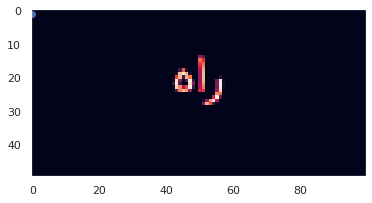

In [165]:
# def show_word(image, word):
#     """Show image with landmarks"""
#     plt.imshow(image)
#     plt.scatter(0, 1)
#     plt.pause(0.001)  # pause a bit so that plots are updated

# plt.figure()
# show_word(io.imread(os.path.join('/content/Shotor/Shotor_Images', img_name)),
#                word)
# plt.show()

In [188]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.word_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.word_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.word_frame.iloc[idx, 0])
        image = io.imread(img_name)
        word = self.word_frame.iloc[idx, 1:]
        word = np.array([word])
        # landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'word': word}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (50, 100) (1, 1)


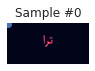

1 (50, 100) (1, 1)


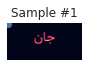

2 (50, 100) (1, 1)


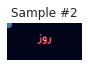

3 (50, 100) (1, 1)


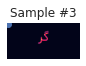

In [189]:
face_dataset = FaceLandmarksDataset(csv_file=pcsv,
                                    root_dir='/content/Shotor/Shotor_Images')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['word'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_word(**sample)

    if i == 3:
        plt.show()
        break

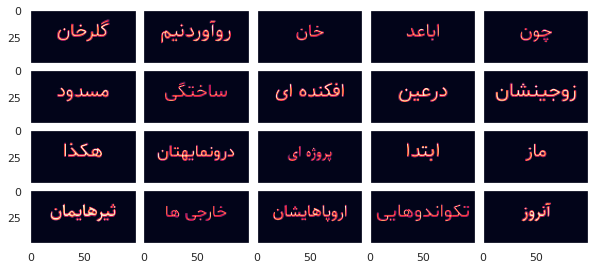

In [190]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10., 12.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 5), axes_pad=0.1)

images = []
for _ in range(20):
  images.append(face_dataset[randint(0, len(face_dataset)-1)]['image'])

for ax, im in zip(grid, images):
    ax.imshow(im)
plt.show()

In [191]:
# define all persian alphabets
pchars = "آ ا ب پ ت ث ج چ ح خ د ذ ر ز ژ س ش ص ض ط ظ ع غ ف ق ک گ ل م ن و ه ی ئ"
pchars = ['-',' ', 'S', 'E'] + pchars.split(' ')
letter_to_index = {}
for i in range(len(pchars)):
  letter_to_index[pchars[i]] = i
enc_dim = len(pchars)

In [192]:
letter_to_index

{' ': 1,
 '-': 0,
 'E': 3,
 'S': 2,
 'آ': 4,
 'ئ': 37,
 'ا': 5,
 'ب': 6,
 'ت': 8,
 'ث': 9,
 'ج': 10,
 'ح': 12,
 'خ': 13,
 'د': 14,
 'ذ': 15,
 'ر': 16,
 'ز': 17,
 'س': 19,
 'ش': 20,
 'ص': 21,
 'ض': 22,
 'ط': 23,
 'ظ': 24,
 'ع': 25,
 'غ': 26,
 'ف': 27,
 'ق': 28,
 'ل': 31,
 'م': 32,
 'ن': 33,
 'ه': 35,
 'و': 34,
 'پ': 7,
 'چ': 11,
 'ژ': 18,
 'ک': 29,
 'گ': 30,
 'ی': 36}

In [193]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, word = sample['image'], sample['word']
        image = image.reshape(-1, 50, 100)
        if (len(word) > word_max_len):
          word = word[:word_max_len]
        word = word + 'E'
        original_word = [[letter_to_index[c]] for c in word]
        return {'image': torch.from_numpy(image).double(),
                'word' : torch.LongTensor(original_word)}

In [194]:
class ImageAug(object):
    """Apply Image Augmentation on style and output"""

    def __call__(self, sample):
        image, word = sample['image'], sample['word']
        aug = iaa.SomeOf((0, 5), [
            iaa.Affine(scale={"x": (0.80, 1.20), "y": (0.80, 1.20)}),
            iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
            iaa.Add((-30, 30)),
            iaa.Multiply((0.80, 1.20)),
            iaa.GaussianBlur(sigma=(0, 0.2))
        ])
        image = aug(images=image)
        return {'image': image,
                'word': word}

In [204]:
transformed_dataset = FaceLandmarksDataset(pcsv, '/content/Shotor/Shotor_Images',
                                 transform=transforms.Compose([ImageAug(), ToTensor()]))

dataloader = DataLoader(transformed_dataset, batch_size=1, shuffle=True)

In [13]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 12805, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 12805 (delta 48), reused 70 (delta 40), pack-reused 12719
Receiving objects: 100% (12805/12805), 12.36 MiB | 24.24 MiB/s, done.
Resolving deltas: 100% (8805/8805), done.
/content/Shotor/yolov5
     |████████████████████████████████| 596 kB 5.1 MB/s 
     |████████████████████████████████| 178 kB 7.6 MB/s 
     |████████████████████████████████| 21.6 MB 7.4 MB/s 
     |████████████████████████████████| 4.3 MB 50.3 MB/s 
     |████████████████████████████████| 145 kB 74.3 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 138 kB 74.1 MB/s 
     |████████████████████████████████| 67 kB 7.4 MB/s 
     |████████████████████████████████| 1.1 MB 63.0 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
ERROR: pip's dependency resolver does not currently take in

In [19]:
!python train.py --img 416 --batch 16 --epochs 150 --data /content/Shotor/char.yml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=/content/Shotor/char.yml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-307-g92e47b8 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7